In [ ]:
#| default_exp utils

In [ ]:
#| export
import os
import pathlib
if "__file__" in globals():#only run in the translated python file, as __file__ is not defined with ipython
    INTABLE_CONFIG = os.path.join(pathlib.Path(__file__).parent.absolute(), "configs", "intable_config.yaml") #the yaml config is located one directory below the python library files
    CONFIG_PATH = os.path.join(pathlib.Path(__file__).parent.absolute(), "configs")

# Utility Functions

## Reformatting and transformation functions

## I/O functions

# Input Parsers
The directlfq pipeline is run using a generic wide-table input format, as specified in the documentation. The following parsers convert long format tables as provided e.g. by Spectronaut or DIA-NN into this generic format. The configuration for the parsers is set by a yaml file.

## Convert long format to wide format

### Parse .yaml file
The relevant parameters for reading and reformatting the long table are stored in the "intable_config.yaml" file. The functions below are for reading and reformating the config info

### Filter and reformat

## check for already processed files

## Wrapper functions

## Test input parsing

### Compare the in-memory and out-of-memory longformat table loadings

In [ ]:
#| include: false

import os
import pandas as pd
import shutil
import matplotlib_venn
import directlfq.utils as lfqutils

print(os.path.abspath("."))
input_file = "../test_data/unit_tests/input_table_formats/spectronaut.frgions.large.tsv"
outdir = "../test_data/unit_tests/input_table_formats/loading_comparisons"

file_default = "default_out.tsv"
file_dask_proc = "dask_proc_out.tsv"

def test_table_loadings(input_file, outdir, file_default, file_dask_proc):
    if not os.path.exists(outdir):
        os.mkdir(outdir)
        #os.chdir(outdir)

    input_type, config_dict_for_type, sep = lfqutils.get_input_type_and_config_dict(input_file)

    lfqutils.reformat_and_write_longtable_according_to_config(input_file,outfile_name=file_dask_proc,config_dict_for_type=config_dict_for_type, enforce_largefile_processing=True, chunksize=10_000)
    lfqutils.reformat_and_write_longtable_according_to_config(input_file,outfile_name=file_default,config_dict_for_type=config_dict_for_type, chunksize=10_000)

    df_default = pd.read_csv(file_default, sep = "\t")

    df_dask_proc = pd.read_csv(file_dask_proc, sep = "\t")


    assert df_default.equals(df_dask_proc)

    matplotlib_venn.venn2([set(df_default["ion"]), set(df_dask_proc["ion"])])

    os.remove(file_default)
    os.remove(file_dask_proc)
    shutil.rmtree(outdir)



/Users/constantin/workspace/directlfq/nbdev_nbs


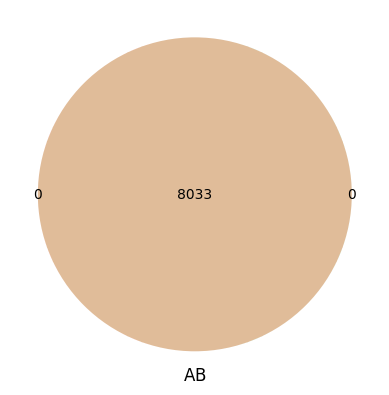

In [ ]:

test_table_loadings(input_file, outdir, file_default, file_dask_proc)

In [ ]:
#| include: false

import directlfq.utils as lfqutils
import os
import shutil
outdir = "../test_data/unit_tests/input_table_formats/"

tabledir ="../test_data/unit_tests/input_table_formats/"
results_dir = "../test_data/unit_tests/results/"


input_files = [os.path.join(tabledir, x ) for x in ["diann.tsv", "spectronaut.tsv", "spectronaut_frgion.tsv", "mq_peptides.txt"]]
samplemap_files = [os.path.join(tabledir, x ) for x in ["samplemap.diann.tsv", "samplemap.spectronaut.tsv", "samplemap.spectronaut.frgions.tsv", "samplemap.mq.tsv"]]





def perform_table_loading(input_file, samplemap_file):
    """only makes sure that the commands run without error"""
    
    #import the input table once the input and the results folder are specified. 
    # The function automatically recognizes the format (Currently MQ, Spectronaut, DIA-NN configured)
    input_data = lfqutils.import_data(input_file)
    #display(input_data)
    
    #get sample names from the imported table
    samplenames = lfqutils.get_samplenames_from_input_df(input_data)
    #display(samplenames)

    #load the samplemap dataframe (in case the user uploads a file. Basically a pandas import + separator check)
    samplemap_df = lfqutils.load_samplemap(samplemap_file)
    #display(samplemap_df)

    #compare samplemap and actual table, merge & logtransform intensities
    input_processed, samplemap_df_processed = lfqutils.prepare_loaded_tables(input_data, samplemap_df)
    #display(input_processed)
    #display(samplemap_df_processed)

for idx in range(len(input_files)):
    perform_table_loading(input_files[idx], samplemap_files[idx])
    print('loading ran through')

loading ran through
loading ran through
loading ran through
loading ran through


In [ ]:
#| include: false
import yaml
import pandas as pd
import numpy as np
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

def compare_generic_table_with_original(preprocessed_input_df, original_input_file, config_yaml,input_typename_config, sep = "\t"):
    id2quant_orig, id2quant_preproc = get_processed_original_id2quant_maps(preprocessed_input_df, original_input_file, config_yaml,input_typename_config)
    keys_orig = set(id2quant_orig.keys())
    keys_preproc = set(id2quant_preproc.keys())
    keydiff = keys_preproc.difference(keys_orig)
    keys_orig = sorted(keys_orig)
    keys_preproc = sorted(keys_preproc)
    print(list(keys_orig)[:10])
    print(list(keys_preproc)[:10])
    
    
    assert(len(keydiff)==0) #check that all keys in the preprocessed set are part of the original set

    venn2([set(id2quant_orig.keys()), set(id2quant_preproc.keys())], ["original", "preprocessed"])
    
    quantvec_orig = np.array([id2quant_orig.get(x)for x in id2quant_preproc.keys()])
    quantvec_preproc = np.array([id2quant_preproc.get(x)for x in id2quant_preproc.keys()])
    unequal_quant = [id2quant_orig.get(x)!=id2quant_preproc.get(x) for x in id2quant_preproc.keys()]
    unequal_quant_scaled = [id2quant_orig.get(x)*10000!=id2quant_preproc.get(x) for x in id2quant_preproc.keys()]
    print(sum(unequal_quant))
    print(sum(unequal_quant_scaled))
    plt.show()
    plt.scatter(quantvec_orig, quantvec_preproc)
    plt.show()
    corrcoeff = np.corrcoef(quantvec_orig,quantvec_preproc)[0][1]
    print(f"correlation between both processings: {corrcoeff}")
    assert(corrcoeff>0.999)



def get_processed_original_id2quant_maps(preprocessed_input_df, original_input_file, config_yaml,input_typename_config, sep = "\t"):
    config_all = yaml.safe_load(open(config_yaml, 'r'))
    config_dict = config_all.get(input_typename_config)
    id_cols = config_dict.get("ion_cols") + [config_dict.get("sample_ID")]
    quant_col = list(config_dict.get("quant_ID").values())
    id2quant_orig = get_id2quant_original(original_input_file, id_cols, quant_col, sep)
    id2quant_preproc = get_id2quant_processed(preprocessed_input_df, id_cols, quant_col)
    return id2quant_orig, id2quant_preproc


def get_id2quant_original(original_input_file, id_cols, quant_col, sep):
    print(id_cols)
    print(id_cols+quant_col)
    orig_df = pd.read_csv(original_input_file, sep=sep, usecols= id_cols+quant_col)
    orig_df["compareID"] = orig_df[id_cols].apply(lambda x: ''.join(x.values.astype(str)), axis=1)
    #orig_df["compareID"] = orig_df[id_cols].astype('string').sum(axis = 1)
    display(orig_df)
    id2quant = dict(zip(orig_df["compareID"], orig_df[quant_col[0]]))
    id2quant = {k: round(v,3) for k, v in id2quant.items()}
    return id2quant


def get_id2quant_processed(preprocessed_input_df, id_cols, quant_col):
    compare_IDs = []
    quantvals = []
    for column in preprocessed_input_df.columns:
        if(column == "protein"):
            continue
        id = pd.Series([column for x in range(len(preprocessed_input_df.index))]).to_numpy()[0]
        reformated_pep_id = [x.split("_MOD_")[1].replace("_CHARGE_", "")[:-1]+id for x in preprocessed_input_df.index]
        compare_IDs.extend(reformated_pep_id)

        quantvals.extend(list(preprocessed_input_df[column]))
    
    id2quant = dict(zip(compare_IDs, quantvals))
    id2quant = {k: round(2**v,3) for k, v in id2quant.items() if ~np.isnan(v)}
    return id2quant






['EG.ModifiedPeptide', 'FG.Charge', 'R.Label']
['EG.ModifiedPeptide', 'FG.Charge', 'R.Label', 'FG.Quantity']


,R.Label,EG.ModifiedPeptide,FG.Charge,FG.Quantity,compareID
0,E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms,_LNVLPVDVLTR_,2,95427.601562,_LNVLPVDVLTR_2E_D170331_S209-S-1-240min_MHRM_R...
1,E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms,_LNVLPVDVLTR_,2,95427.601562,_LNVLPVDVLTR_2E_D170331_S209-S-1-240min_MHRM_R...
2,E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms,_LNVLPVDVLTR_,2,95427.601562,_LNVLPVDVLTR_2E_D170331_S209-S-1-240min_MHRM_R...
3,E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms,_LNVLPVDVLTR_,2,95427.601562,_LNVLPVDVLTR_2E_D170331_S209-S-1-240min_MHRM_R...
4,E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms,_LNVLPVDVLTR_,2,95427.601562,_LNVLPVDVLTR_2E_D170331_S209-S-1-240min_MHRM_R...
...,...,...,...,...,...
9994,E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms,_GC[Carbamidomethyl (C)]VITISGR_,2,110807.851562,_GC[Carbamidomethyl (C)]VITISGR_2E_D170331_S20...
9995,E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms,_GC[Carbamidomethyl (C)]VITISGR_,2,110807.851562,_GC[Carbamidomethyl (C)]VITISGR_2E_D170331_S20...
9996,E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms,_GC[Carbamidomethyl (C)]VITISGR_,2,110807.851562,_GC[Carbamidomethyl (C)]VITISGR_2E_D170331_S20...
9997,E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms,_GC[Carbamidomethyl (C)]VITISGR_,2,110807.851562,_GC[Carbamidomethyl (C)]VITISGR_2E_D170331_S20...


['_AAAAASAAGPGGLVAGKEEK_2E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAAAASAAGPGGLVAGKEEK_3E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAAAASAAGPGGLVAGK_2E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAANFSDR_2E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAAPEKPDAEHDAPQFIEPLDSIDR_4E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAFDVIVR_2E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAGAILK_1E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAGEHIASSGK_2E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAGIWYEHR_3E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AALAATGAASGGGGGGGGAGSR_2E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms']
['_AAAAASAAGPGGLVAGKEEK_2E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAAAASAAGPGGLVAGKEEK_3E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAAAASAAGPGGLVAGK_2E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAANFSDR_2E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAAPEKPDAEHDAPQFIEPLDSIDR_4E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAFDVIVR_

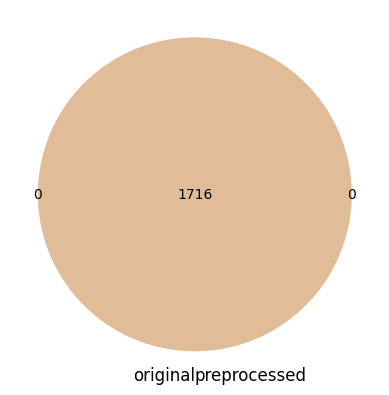

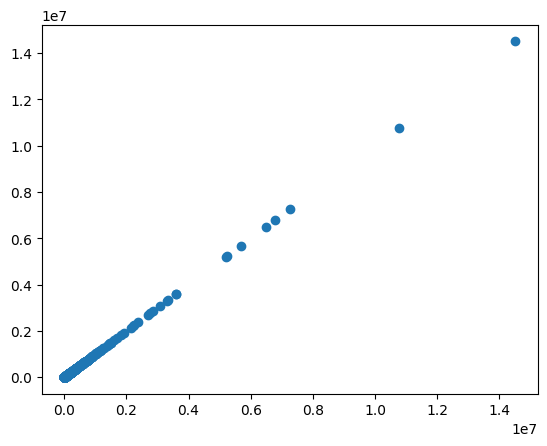

correlation between both processings: 1.0


In [ ]:

input_file = os.path.join(tabledir, "spectronaut.tsv")
samplemap_file = os.path.join(tabledir, "samplemap.spectronaut.tsv")


input_data = lfqutils.import_data(input_file)
samplemap_df = lfqutils.load_samplemap(samplemap_file)
input_processed, samplemap_df_processed = lfqutils.prepare_loaded_tables(input_data, samplemap_df)
compare_generic_table_with_original(input_processed, input_file, "../directlfq/configs/intable_config.yaml", "spectronaut_precursor_v2")